In [1]:
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
import torchvision
import shutil

nose_iteration_size = 15
probe_image_index = 1
nose_dataset_dir = Path("/app/datasets/gaussian_nose")
loose_crop_path = nose_dataset_dir / "loose_crop"

In [92]:
# create blured images
gaussian_blur = torchvision.transforms.GaussianBlur(kernel_size=256 / 10, sigma=3)
shutil.rmtree(nose_dataset_dir, ignore_errors=True)
nose_dataset_dir.mkdir(exist_ok=True)
loose_crop_path.mkdir(exist_ok=True)

ids = [0, 1, 2]

for id in ids:
    probe_image_path = Path("/app/datasets/interpolation/loose_crop") / (
        str(id) + "_" + str(probe_image_index).zfill(4) + ".jpg"
    )
    initial_image = plt.imread(probe_image_path)
    plt.imsave(
        loose_crop_path
        / (str(id) + f"_{probe_image_index}_" + str(0).zfill(4) + ".jpg"),
        initial_image,
    )
    blured_images = [initial_image]
    for i in range(nose_iteration_size):
        prev_image = Image.fromarray(blured_images[-1])
        new_image = gaussian_blur(prev_image)
        blured_images.append(np.array(new_image))
        plt.imsave(
            loose_crop_path
            / (str(id) + f"_{probe_image_index}_" + str(i + 1).zfill(4) + ".jpg"),
            np.array(new_image),
        )
        # plt.imshow(new_image)

In [93]:
# create meta file
meta_dir = nose_dataset_dir / "meta"
meta_dir.mkdir(exist_ok=True)

with open("/app/datasets/interpolation/meta/inter_name_5pts_score.txt") as fd:
    img_records = np.array([ii.strip().split(" ") for ii in fd.readlines()])
landmarks = img_records[:, 1:-1].astype("float32")  # .reshape(-1, 5, 2)
id_to_landmarks = {}

with open(meta_dir / "nose_name_5pts_score.txt", "w") as fd:
    for id in range(3):
        landmark = landmarks[id * 9 + probe_image_index]
        id_to_landmarks[id] = landmark
        landmark = landmark.astype("str").tolist()
        rows = [
            [
                str(id) + f"_{probe_image_index}_" + str(0).zfill(4) + ".jpg",
                *landmark,
                str(1.0),
            ]
        ]
        for i in range(nose_iteration_size):
            name = str(id) + f"_{probe_image_index}_" + str(i + 1).zfill(4) + ".jpg"
            rows.append([name, *landmark, str(1.0)])
        for data in rows:
            fd.write(" ".join(data) + "\n")

In [2]:
# load probe embeddings

id_to_gallery_emb = {id: [] for id in range(3)}
embs = np.load("/app/cache/features/scf_embs_inter.npz")
for i in range(3):
    id_to_gallery_emb[i].append(embs["embs"][i * 9 + 0][np.newaxis, :])
    id_to_gallery_emb[i].append(embs["embs"][i * 9 + 8][np.newaxis, :])

id_to_probe_emb = {id: [] for id in range(3)}
id_to_probe_unc = {id: [] for id in range(3)}
embs_probe = np.load("/app/cache/features/scf_embs_nose.npz")
for id in range(3):
    for i in range(nose_iteration_size + 1):
        id_to_probe_emb[id].append(
            embs_probe["embs"][id * (nose_iteration_size + 1) + i]
        )
        id_to_probe_unc[id].append(
            embs_probe["unc"][id * (nose_iteration_size + 1) + i, 0]
        )

In [3]:
from hydra.utils import instantiate

T = 0.28836
T_data_unc = 5
power_recognition_method = {
    "_target_": "evaluation.open_set_methods.posterior_prob_based.PosteriorProbability",
    "class_model": "power",
    "kappa": 0.3,
    "beta": 0.5,
    "uncertainty_type": "maxprob",
    "alpha": 0,
    "aggregation": "sum",
    "T": T,
    "T_data_unc": T_data_unc,
    "kappa_is_tau": True,
}

scf_recognition_method = {
    "_target_": "evaluation.open_set_methods.posterior_prob_based.PosteriorProbability",
    "class_model": "power",
    "kappa": 0.3,
    "beta": 0.5,
    "uncertainty_type": "maxprob",
    "alpha": 1,
    "aggregation": "sum",
    "T": T,
    "T_data_unc": T_data_unc,
    "kappa_is_tau": True,
}

sum_recognition_method = {
    "_target_": "evaluation.open_set_methods.posterior_prob_based.PosteriorProbability",
    "class_model": "power",
    "kappa": 0.3,
    "beta": 0.5,
    "uncertainty_type": "maxprob",
    "alpha": 0.5,
    "aggregation": "sum",
    "T": T,
    "T_data_unc": T_data_unc,
    "kappa_is_tau": True,
}

power_unc_predictor = instantiate(power_recognition_method)
scf_unc_predictor = instantiate(scf_recognition_method)
sum_unc_predictor = instantiate(sum_recognition_method)

Tau 0.3, kappa 363.52
Tau 0.3, kappa 363.52
Tau 0.3, kappa 363.52


/tmp/ipykernel_17139/2027451005.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs_prob[0].set_yticklabels(np.around(np.array([-50,0, 50, 100, 150, 200])/ 256, 1))


Tau 0.3, kappa 363.52
Tau 0.3, kappa 363.52
Tau 0.3, kappa 363.52


/tmp/ipykernel_17139/2027451005.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs_prob[0].set_yticklabels(np.around(np.array([-50,0, 50, 100, 150, 200])/ 256, 1))


Tau 0.3, kappa 363.52
Tau 0.3, kappa 363.52
Tau 0.3, kappa 363.52


/tmp/ipykernel_17139/2027451005.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs_prob[0].set_yticklabels(np.around(np.array([-50,0, 50, 100, 150, 200])/ 256, 1))


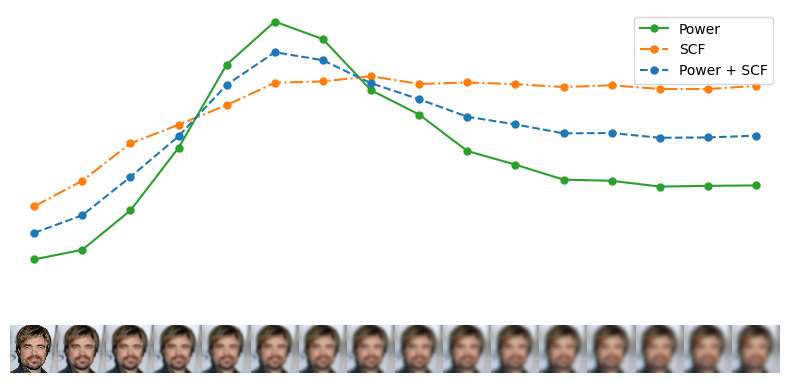

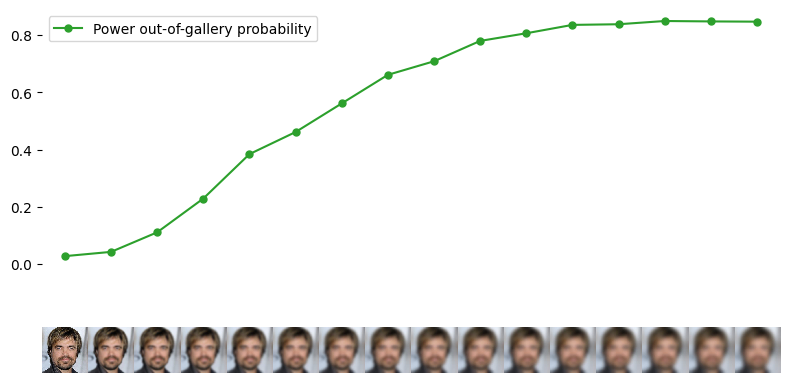

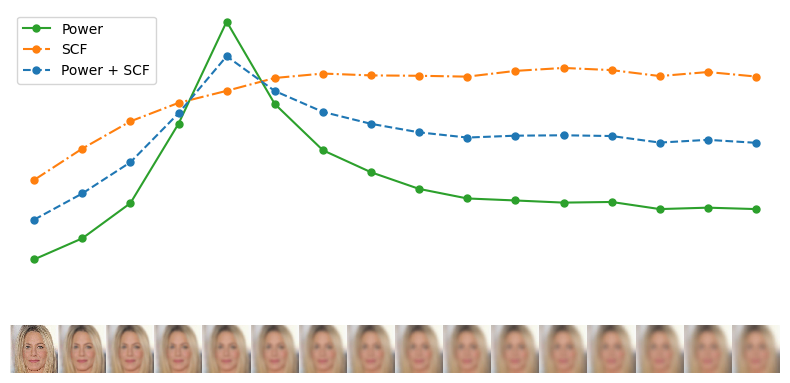

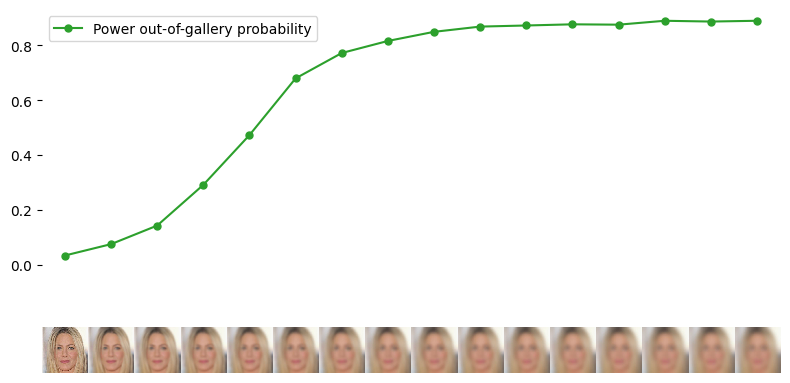

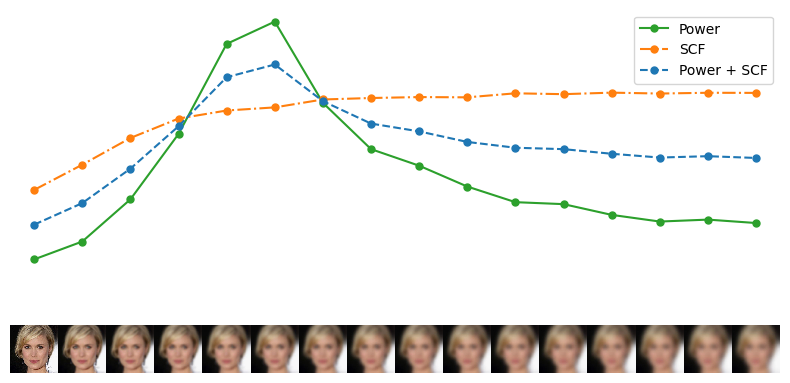

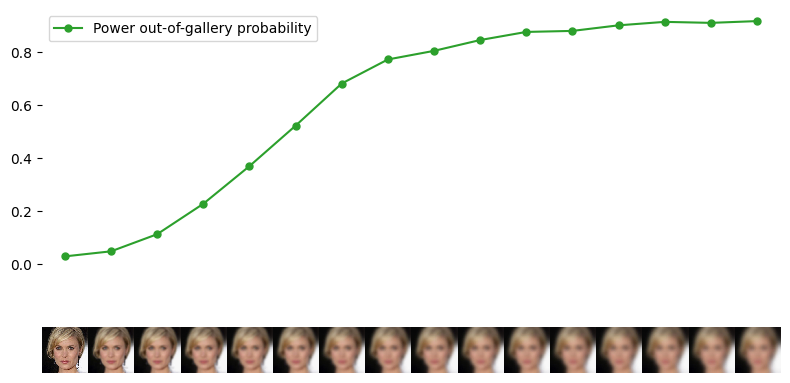

In [4]:
# compute uncertainty and create plots
test_id = 1
ids = [0, 1, 2]
# import seaborn as sns
# sns.set_theme()
for test_id in ids:
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5), frameon=False)
    gallery_embeddings = np.concatenate(id_to_gallery_emb[test_id])

    probe_embeddings = []
    for j in np.arange(0, nose_iteration_size + 1):
        probe_embeddings.append(id_to_probe_emb[test_id][j])
    probe_embeddings = np.array(probe_embeddings)

    similarity_matrix = probe_embeddings @ gallery_embeddings.T
    similarity_matrix = similarity_matrix[:, np.newaxis, :]

    # compute unc
    power_unc_predictor.setup(similarity_matrix)
    scf_unc_predictor.setup(similarity_matrix)
    sum_unc_predictor.setup(similarity_matrix)

    probe_kappa = np.exp(id_to_probe_unc[test_id])[:, np.newaxis]
    power_predicted_unc = power_unc_predictor.predict_uncertainty(probe_kappa)
    power_probs = np.exp(power_unc_predictor.all_classes_log_prob)
    scf_predicted_unc = scf_unc_predictor.predict_uncertainty(probe_kappa)
    sum_predicted_unc = sum_unc_predictor.predict_uncertainty(probe_kappa)

    scale = 256
    shift = 256 / 2
    x = np.arange(nose_iteration_size + 1) * scale + shift

    axs[0].plot(
        x,
        power_predicted_unc * scale,
        marker="o",
        markersize=5,
        label="Power",
        color="tab:green",
    )
    axs[0].plot(
        x,
        scf_predicted_unc * scale,
        marker="o",
        markersize=5,
        label="SCF",
        color="tab:orange",
        linestyle="dashdot",
    )
    axs[0].plot(
        x,
        sum_predicted_unc * scale,
        marker="o",
        markersize=5,
        label="Power + SCF",
        linestyle="--",
        color="tab:blue",
    )
    axs[0].axis("off")
    axs[0].legend()

    blured_images = []
    for i in range(nose_iteration_size + 1):
        image_path = str(
            loose_crop_path
            / (str(test_id) + f"_{probe_image_index}_" + str(i).zfill(4) + ".jpg")
        )
        blured_images.append(plt.imread(image_path))
    # gallery images outline
    axs[1].imshow(np.concatenate(blured_images, axis=1), interpolation="none")
    axs[1].axis("off")
    fig.tight_layout()
    fig.savefig(
        f"/app/paper_assets/images/nose_{test_id}",
        dpi=300,
        bbox_inches="tight",
        pad_inches=0,
    )
    fig_prob, axs_prob = plt.subplots(2, 1, sharex=True, figsize=(8, 5), frameon=False)
    axs_prob[0].plot(
        x,
        power_probs[:, -1] * scale,
        label="Power out-of-gallery probability",
        color="tab:green",
        marker="o",
        markersize=5,
    )
    # labels = [str(int(item.get_text())/256) for item in axs_prob[0].get_yticklabels()[1:]]
    # axs_prob[0].set_yticklabels(labels)
    # axs_prob[0].axis("off")
    # axs_prob[0].set_yticks(['-50','0', '50', '100', '150', '200'], np.array([-50,0, 50, 100, 150, 200])/ 256)
    axs_prob[0].set_yticklabels(
        np.around(np.array([-50, 0, 50, 100, 150, 200]) / 256, 1)
    )
    axs_prob[0].spines["top"].set_visible(False)
    axs_prob[0].spines["right"].set_visible(False)
    axs_prob[0].spines["bottom"].set_visible(False)
    axs_prob[0].set_xticks([])
    axs_prob[0].spines["left"].set_visible(False)
    axs_prob[0].legend()
    axs_prob[1].imshow(np.concatenate(blured_images, axis=1), interpolation="none")
    axs_prob[1].axis("off")
    fig_prob.tight_layout()
    fig_prob.savefig(
        f"/app/paper_assets/images/nose_{test_id}_prob",
        dpi=300,
        bbox_inches="tight",
        pad_inches=0,
    )

In [22]:
l = [item.get_text() for item in axs_prob[0].get_yticklabels()]

In [25]:
int(l[0])

ValueError: invalid literal for int() with base 10: '−50'

In [19]:
labels

['−50', '0', '50', '100', '150', '200', '250']

In [112]:
nose_iteration_size

15